# RAMSES Nebular Line Emission

Braden Nowicki

Script to visualize RAMSES-RT Simulations of high-redshift galaxies in a variety of metal lines. Ionization Parameter, Number Density, and Temperature for each pixel are input into an interpolator for each line; the interpolator is created via the module 'emission.py'. 'emission.py' currently uses the 'linelist.dat' datatable to build interpolators; this can be adjusted to work with other tables from Cloudy runs. 

In [62]:
# importing packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import emission

import yt
from yt.units import dimensions
import copy

'''
cell_fields = [
    "Density",
    "x-velocity",
    "y-velocity",
    "z-velocity",
    "Pressure",
    "Metallicity",
    # "dark_matter_density",
    "xHI",
    "xHII",
    "xHeII",
    "xHeIII",
]
epf = [
    ("particle_family", "b"),
    ("particle_tag", "b"),
    ("particle_birth_epoch", "d"),
    ("particle_metallicity", "d"),
]
'''

# Cloudy Grid Run Bounds (log values)
# Umin, Umax, Ustep: -6.0 1.0 0.5
# Nmin, Nmax, Nstep: -1.0 6.0 0.5 
# Tmin, Tmax, Tstop: 3.0 6.0 0.1

lines=["H1_6562.80A","O1_1304.86A","O1_6300.30A","O2_3728.80A","O2_3726.10A","O3_1660.81A",
       "O3_1666.15A","O3_4363.21A","O3_4958.91A","O3_5006.84A", "He2_1640.41A","C2_1335.66A",
       "C3_1906.68A","C3_1908.73A","C4_1549.00A","Mg2_2795.53A","Mg2_2802.71A","Ne3_3868.76A",
       "Ne3_3967.47A","N5_1238.82A","N5_1242.80A","N4_1486.50A","N3_1749.67A","S2_6716.44A","S2_6730.82A"]

# Returns a function for line emission of index idx;
# Allows for the batch creation of intensity fields
# for a variety of lines
def get_line_emission(idx):
    def _line_emission(field, data):
        interpolator=emission.get_interpolator(idx)
        # change to log values
        #U_val = data['gas', 'ion-param'].value
        #N_val = data['gas', 'number_density'].value
        #T_val = data['gas', 'temperature'].value

        #T_val = np.where(T_val < 0.0, 10e-6, T_val)

        #U = np.log10(U_val)
        #N = np.log10(N_val)
        #T = np.log10(T_val)

        U = np.log10(data['gas', 'ion-param'].value)
        N = np.log10(data['gas', 'number_density'].value)
        T = np.log10(data['gas', 'temperature'].value)

        # Adjust log values to within bounds supported by
        # interpolation table
        Uadj = np.where(U < -6.0, -6.0, U)
        Uadj = np.where(Uadj > 1.0, 1.0, Uadj)

        Nadj = np.where(N < -1.0, -1.0, N)
        Nadj = np.where(Nadj > 6.0, 6.0, Nadj)

        Tadj = np.where(T < 3.0, 3.0, T)
        Tadj = np.where(Tadj > 6.0, 6.0, Tadj)
    
        tup = np.stack((Uadj, Nadj, Tadj), axis=-1)

        # Return interpolated values weighted by metallicity
        # TODO dont weight H and He by metallicity
        return interpolator(tup)*data['gas', 'metallicity']/data['gas', 'metallicity']
    return copy.deepcopy(_line_emission)

# Ionization Parameter Field
# Based on photon densities bins 1-4
# TODO check ionization parameter
def _ion_param(field, data): 
    #photon=data['ramses-rt', 'Photon_density_1']+data['ramses-rt', 'Photon_density_2'] + data['ramses-rt', 'Photon_density_3'] + data['ramses-rt', 'Photon_density_4']
    photon=data['ramses-rt', 'Photon_density_2'] + data['ramses-rt', 'Photon_density_3'] + data['ramses-rt', 'Photon_density_4']

    return photon/data['gas', 'number_density']  

yt.add_field(
    ('gas', 'ion-param'), 
    function=_ion_param, 
    sampling_type="cell", 
    units="cm**3", 
    force_override=True
)

# Add intensity fields for all lines in the list
for i in range(len(lines)):
    yt.add_field(
        ('gas', 'intensity_' + lines[i] + '_[erg_cm^{-2}_s^{-1}]'),
        function=get_line_emission(i),
        sampling_type='cell',
        units='1',
        force_override=True
    )


def _halpha_emission(field, data):
    interpolator=emission.get_interpolator(0)
    # change to log values
    U = np.log10(data['gas', 'ion-param'].value)
    N = np.log10(data['gas', 'number_density'].value)
    T = np.log10(data['gas', 'temperature'].value)

    Uadj = np.where(U < -6.0, -6.0, U)
    Uadj = np.where(Uadj > 1.0, 1.0, Uadj)

    Nadj = np.where(N < -1.0, -1.0, N)
    Nadj = np.where(Nadj > 6.0, 6.0, Nadj)

    Tadj = np.where(T < 3.0, 3.0, T)
    Tadj = np.where(Tadj > 6.0, 6.0, Tadj)
    
    tup = np.stack((Uadj, Nadj, Tadj), axis=-1)
    return interpolator(tup)*data['gas', 'metallicity']

yt.add_field(
    ('gas', 'halpha_emission'),
    function=_halpha_emission,
    sampling_type='cell',
    #units='erg cm**-2 s**-1',
    units='1',
    #dimension=dimensions,
    #units='auto',
    #dimensions=dimensions.pressure,
    force_override=True
)

def _OIII_emission(field, data):
    interpolator=emission.get_interpolator(9)
    # change to log values
    U = np.log10(data['gas', 'ion-param'].value)
    N = np.log10(data['gas', 'number_density'].value)
    T = np.log10(data['gas', 'temperature'].value)

    Uadj = np.where(U < -6.0, -6.0, U)
    Uadj = np.where(Uadj > 1.0, 1.0, Uadj)

    Nadj = np.where(N < -1.0, -1.0, N)
    Nadj = np.where(Nadj > 6.0, 6.0, Nadj)

    Tadj = np.where(T < 3.0, 3.0, T)
    Tadj = np.where(Tadj > 6.0, 6.0, Tadj)
    
    tup = np.stack((Uadj, Nadj, Tadj), axis=-1)
    return interpolator(tup)*data['gas', 'metallicity']

yt.add_field(
    ('gas', 'OIII_emission'),
    function=_OIII_emission,
    sampling_type='cell',
    units='1',
    force_override=True
)


f1 = "/Users/bnowicki/Documents/Research/Ricotti/output_00273"

ds = yt.load(f1)
ad = ds.all_data()

ds.fields


yt : [INFO     ] 2024-10-17 17:05:42,572 Parameters: current_time              = 4.311420483661945
yt : [INFO     ] 2024-10-17 17:05:42,572 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2024-10-17 17:05:42,573 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-17 17:05:42,574 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-17 17:05:42,574 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-17 17:05:42,574 Parameters: current_redshift          = 12.171087046255657
yt : [INFO     ] 2024-10-17 17:05:42,575 Parameters: omega_lambda              = 0.685000002384186
yt : [INFO     ] 2024-10-17 17:05:42,575 Parameters: omega_matter              = 0.314999997615814
yt : [INFO     ] 2024-10-17 17:05:42,575 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-10-17 17:05:42,575 Parameters: hubble_constant           = 0.674000015258789
yt : [INFO     ] 2024-10-17 17:05:42,583 Detected RAMSES-RT 

In [ ]:
# Ionization parameter - ramses-rt/rt - divide by cgs_c?
# density squared dependence in OIII emission

# interpolate for density, set temp and ion param const -> see how emission scales with density squared roughly

# gas metallicity in solar or not? divide by 0.02?

# Cloudy manual definition of U

# rt field dimension photon density
# photons per volume, U = density/den gas dimensionless
# add all bins above 1 (not ionization)
# 2 should be higher than 3, 4- low energy photons 
# spectrum input cloudy
# 

yt : [INFO     ] 2024-10-16 22:20:41,201 Projection completed
yt : [INFO     ] 2024-10-16 22:20:41,213 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-16 22:20:41,214 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-16 22:20:41,220 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-16 22:20:41,220 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-16 22:20:41,223 Making a fixed resolution buffer of (('gas', 'ion-param')) 1000 by 1000
yt : [INFO     ] 2024-10-16 22:20:41,877 Saving plot info_00273_Projection_z_ion-param_number_density.png



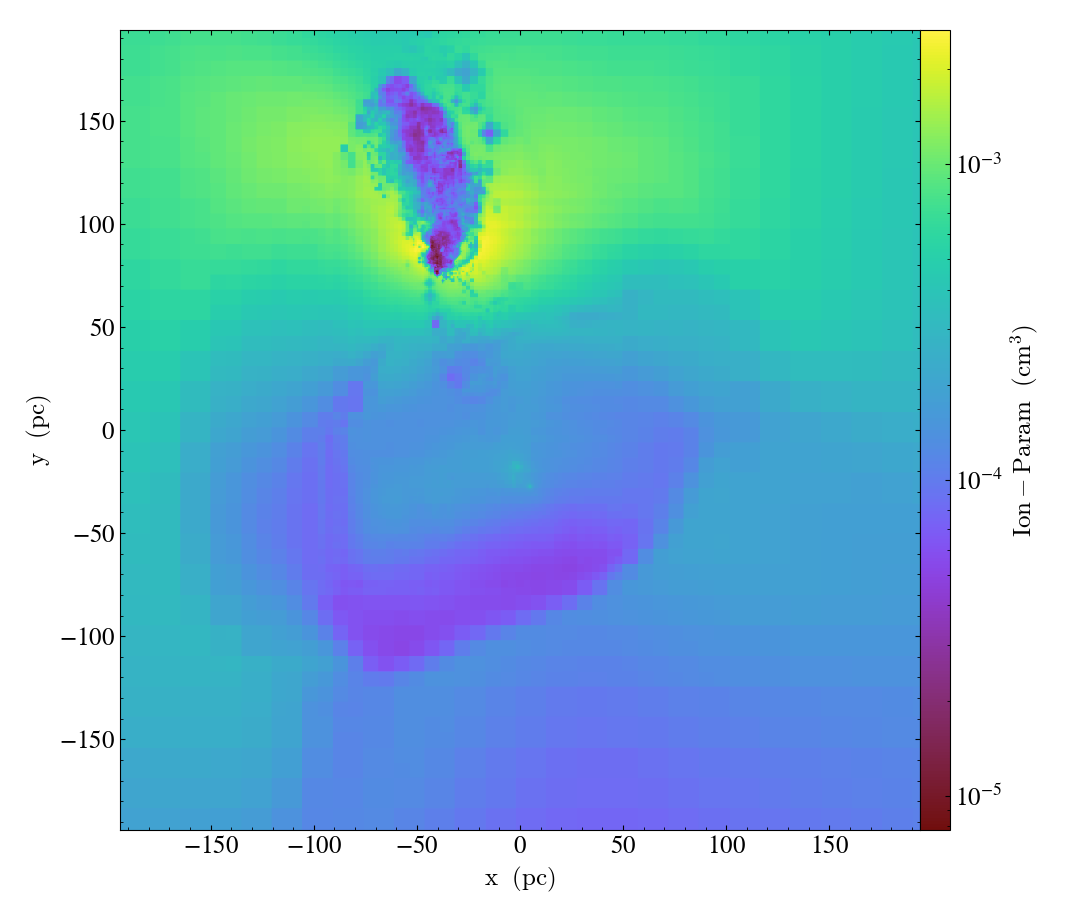

In [2]:
p = yt.ProjectionPlot(ds, "z", ("gas", "ion-param"), width=0.0001,
                      weight_field=("gas", "number_density"),
                      buff_size=(1000, 1000),
                      center=[0.49118094, 0.49275361, 0.49473726])

p.save()
p.show()

yt : [INFO     ] 2024-10-16 22:21:00,299 Projection completed
yt : [INFO     ] 2024-10-16 22:21:00,301 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-16 22:21:00,301 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-16 22:21:00,303 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-16 22:21:00,303 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-16 22:21:00,304 Making a fixed resolution buffer of (('gas', 'temperature')) 1000 by 1000
yt : [INFO     ] 2024-10-16 22:21:00,525 Saving plot info_00273_Projection_z_temperature_number_density.png



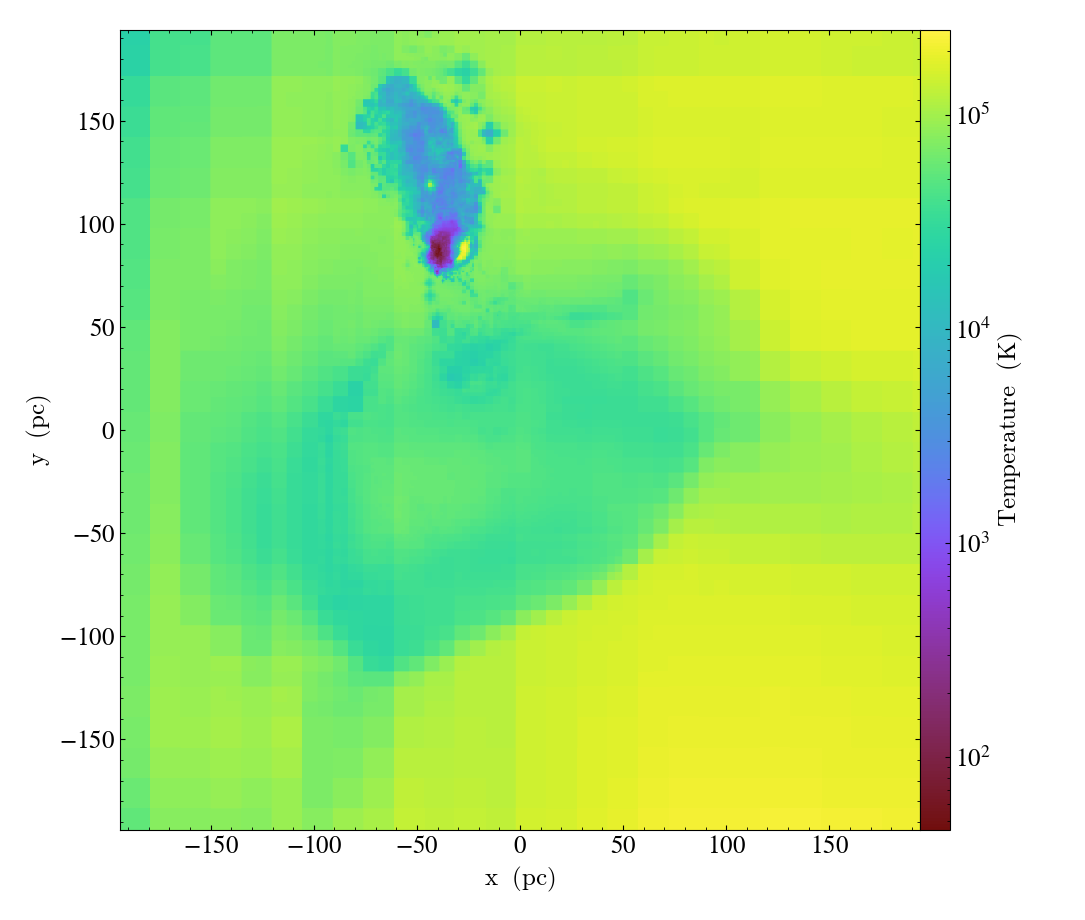

In [3]:
p = yt.ProjectionPlot(ds, "z", ("gas", "temperature"), width=0.0001,
                      weight_field=("gas", "number_density"),
                      buff_size=(1000, 1000),
                      center=[0.49118094, 0.49275361, 0.49473726])

p.save()
p.show()

yt : [INFO     ] 2024-10-16 22:21:14,450 Projection completed
yt : [INFO     ] 2024-10-16 22:21:14,451 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-16 22:21:14,451 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-16 22:21:14,453 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-16 22:21:14,454 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-16 22:21:14,455 Making a fixed resolution buffer of (('gas', 'density')) 1000 by 1000
yt : [INFO     ] 2024-10-16 22:21:14,874 Saving plot info_00273_Projection_z_density_number_density.png



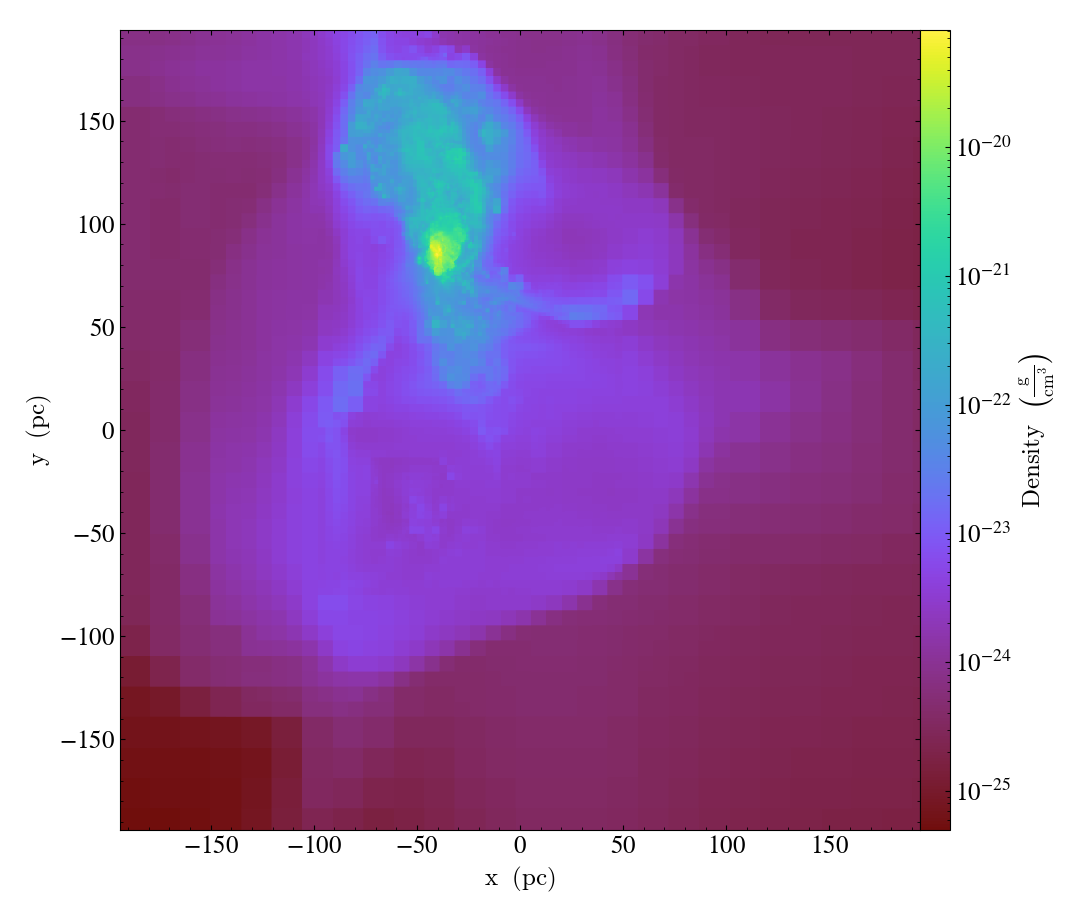

In [4]:
p = yt.ProjectionPlot(ds, "z", ("gas", "density"), width=0.0001,
                      weight_field=("gas", "number_density"),
                      buff_size=(1000, 1000),
                      center=[0.49118094, 0.49275361, 0.49473726])

p.save()
p.show()

yt : [INFO     ] 2024-10-16 22:21:28,428 Projection completed
yt : [INFO     ] 2024-10-16 22:21:28,429 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-16 22:21:28,430 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-16 22:21:28,431 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-16 22:21:28,431 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-16 22:21:28,432 Making a fixed resolution buffer of (('gas', 'metallicity')) 1000 by 1000
yt : [INFO     ] 2024-10-16 22:21:28,636 Saving plot info_00273_Projection_z_metallicity_number_density.png



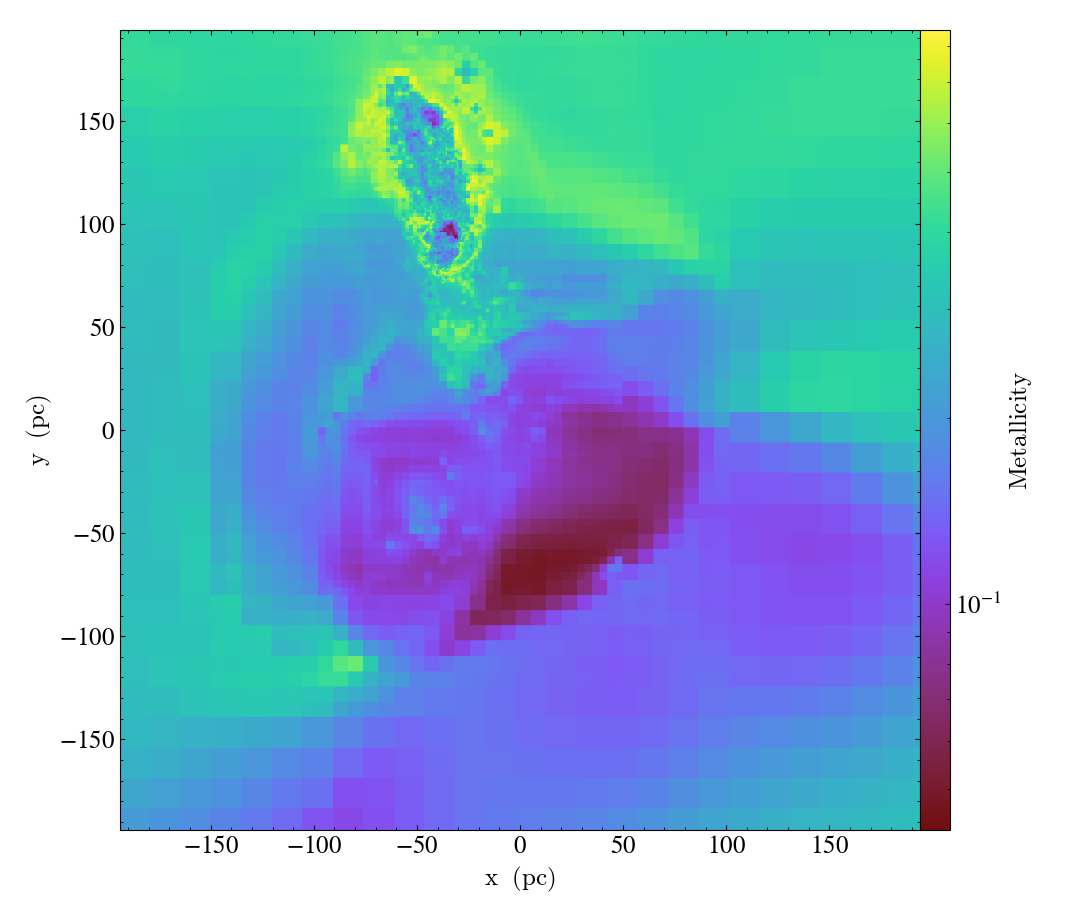

In [5]:
p = yt.ProjectionPlot(ds, "z", ("gas", "metallicity"), width=0.0001,
                      weight_field=("gas", "number_density"),
                      buff_size=(1000, 1000),
                      center=[0.49118094, 0.49275361, 0.49473726])

p.save()
p.show()

/var/folders/rh/cscbbcyd02lfdp3qqy7mdmjm0000gn/T/ipykernel_89127/3328924303.py:63: RuntimeWarning: divide by zero encountered in log10
  T = np.log10(data['gas', 'temperature'].value)
yt : [INFO     ] 2024-10-17 15:44:41,210 Projection completed
yt : [INFO     ] 2024-10-17 15:44:41,213 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-17 15:44:41,213 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-17 15:44:41,215 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-17 15:44:41,215 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-17 15:44:41,217 Making a fixed resolution buffer of (('gas', 'intensity_H1_6562.80A_[erg_cm^{-2}_s^{-1}]')) 1000 by 1000



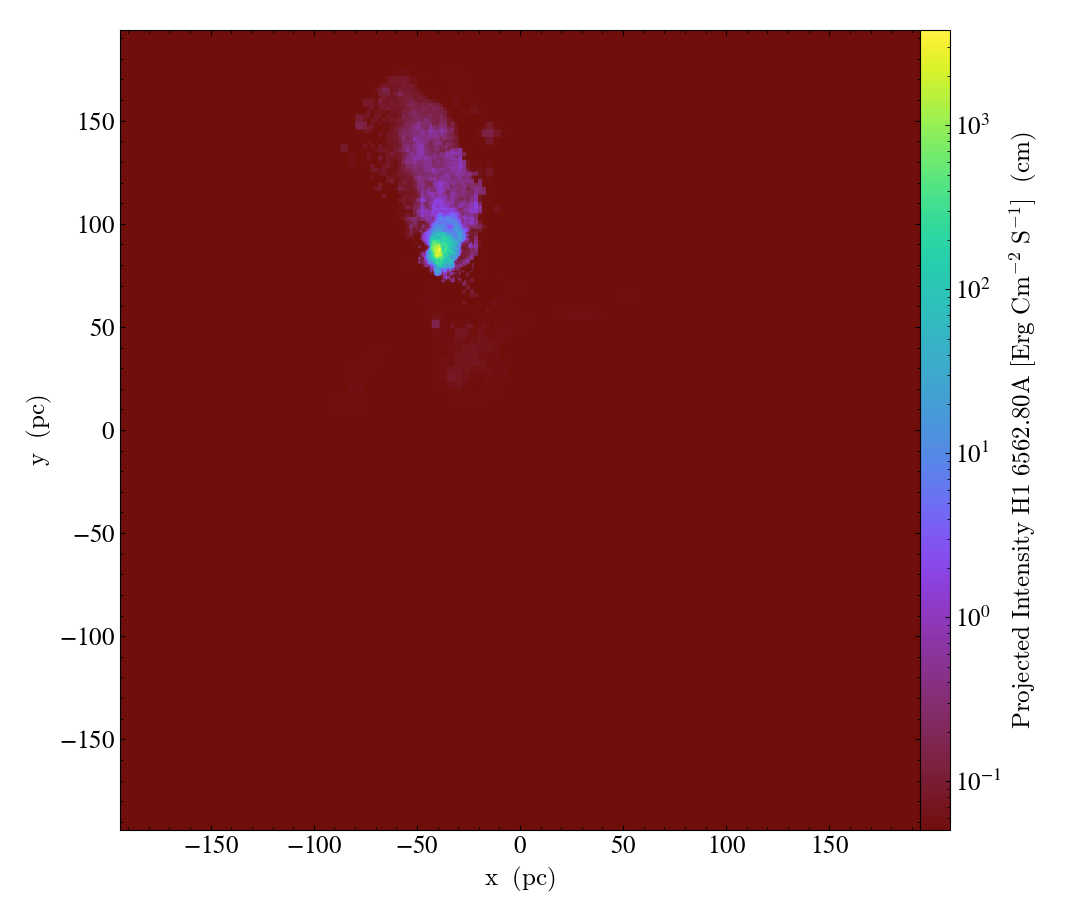

In [36]:
p = yt.ProjectionPlot(ds, "z", ("gas", "intensity_H1_6562.80A_[erg_cm^{-2}_s^{-1}]"), width=0.0001,
                      #weight_field=("gas", "number_density"),
                      buff_size=(1000, 1000),
                      center=[0.49118094, 0.49275361, 0.49473726])
#p.save()
p.show()

/var/folders/rh/cscbbcyd02lfdp3qqy7mdmjm0000gn/T/ipykernel_89127/3328924303.py:63: RuntimeWarning: divide by zero encountered in log10
  T = np.log10(data['gas', 'temperature'].value)
yt : [INFO     ] 2024-10-17 15:43:04,630 Projection completed
yt : [INFO     ] 2024-10-17 15:43:04,633 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-17 15:43:04,635 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-17 15:43:04,637 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-17 15:43:04,637 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-17 15:43:04,638 Making a fixed resolution buffer of (('gas', 'intensity_O3_5006.84A_[erg_cm^{-2}_s^{-1}]')) 1000 by 1000



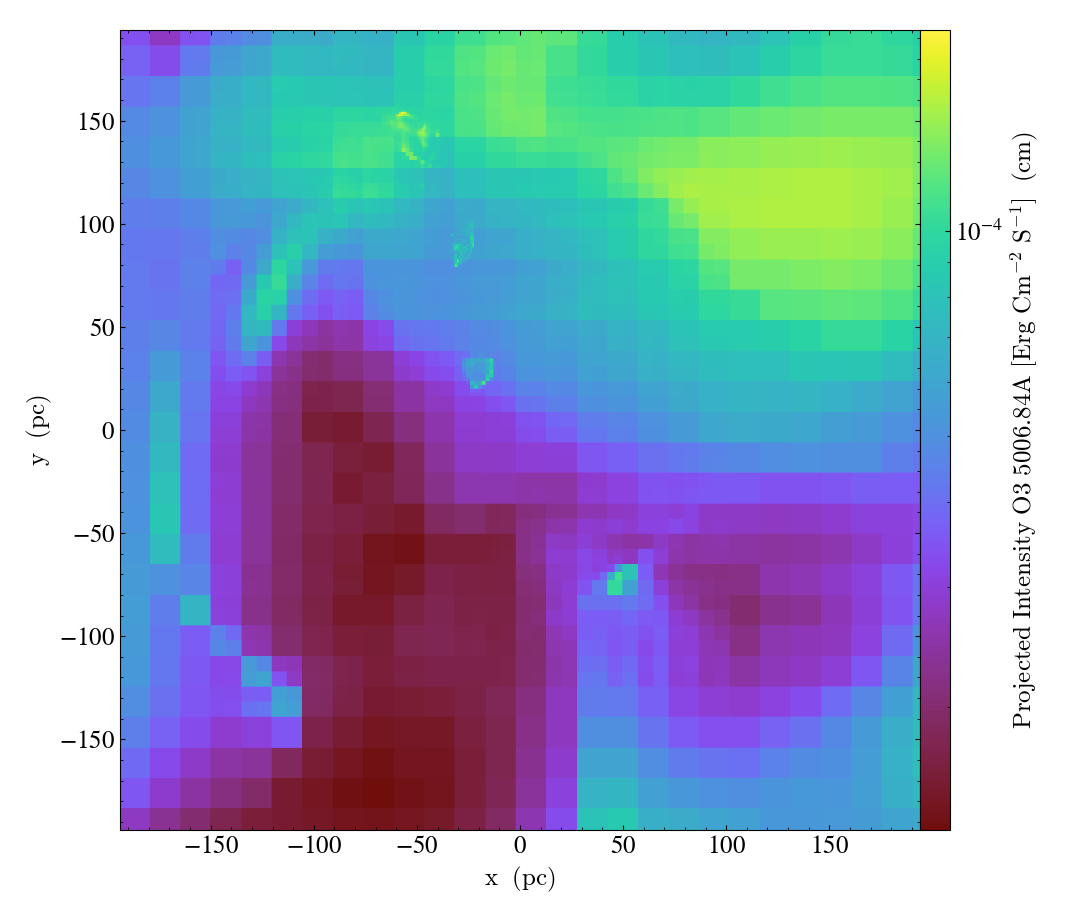

In [33]:
p = yt.ProjectionPlot(ds, "z", ("gas", "intensity_O3_5006.84A_[erg_cm^{-2}_s^{-1}]"), width=0.0001,
                      #weight_field=("gas", "number_density"),
                      buff_size=(1000, 1000),
                      center=[0.49118094, 0.49275361, 0.49473726])
#p.save()
# spherical region - large box, long thin cylinder, bad resolution in edges
p.show()

/var/folders/rh/cscbbcyd02lfdp3qqy7mdmjm0000gn/T/ipykernel_89127/3933899229.py:144: RuntimeWarning: divide by zero encountered in log10
  T = np.log10(data['gas', 'temperature'].value)
yt : [INFO     ] 2024-10-17 13:29:05,470 Projection completed
yt : [INFO     ] 2024-10-17 13:29:05,478 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-17 13:29:05,479 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-17 13:29:05,483 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-17 13:29:05,484 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-17 13:29:05,485 Making a fixed resolution buffer of (('gas', 'OIII_emission')) 1000 by 1000



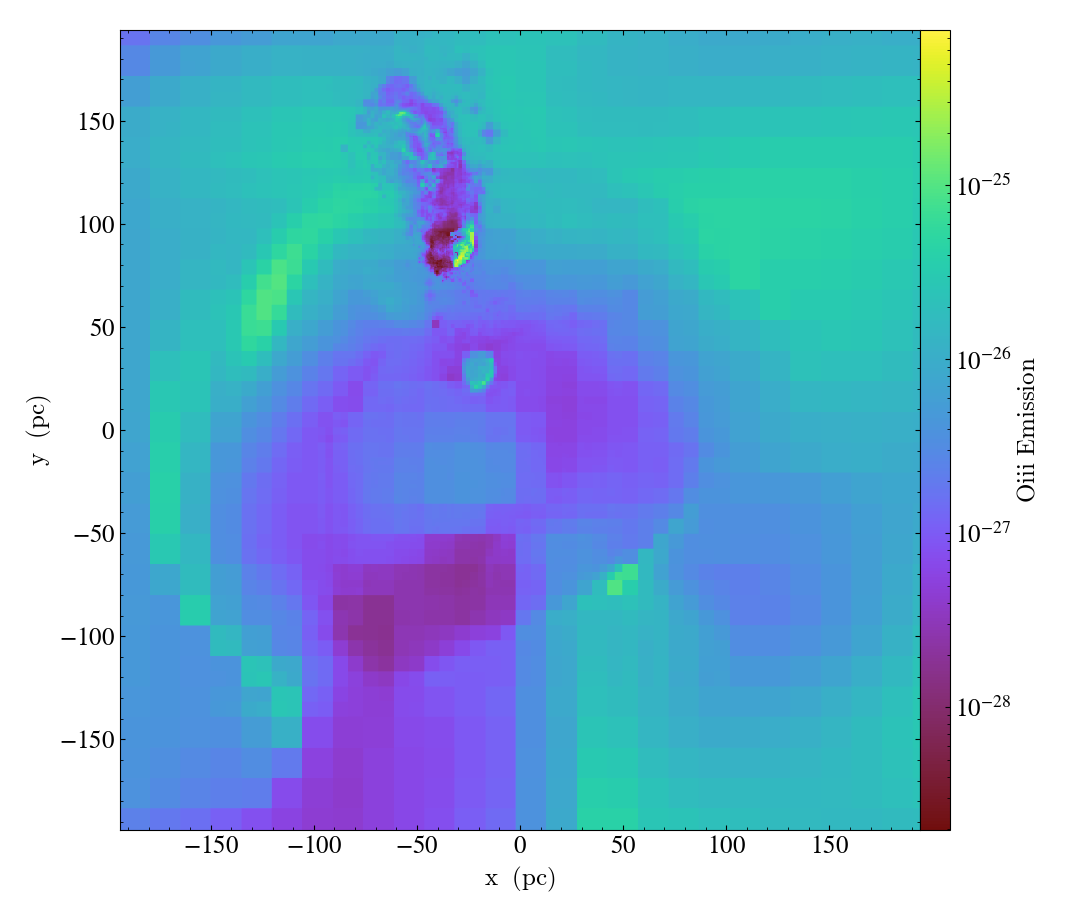

In [31]:
p = yt.ProjectionPlot(ds, "z", ("gas", "OIII_emission"), width=0.0001,
                      weight_field=("gas", "number_density"),
                      buff_size=(1000, 1000),
                      center=[0.49118094, 0.49275361, 0.49473726])

p.show()

## OII Ratio

### Calculate OII Ratio at each Pixel then Project

In [5]:
# Ratio between two OII line emissions acts as an observational diagnostic
# of electron density
def _OII_ratio(field, data):
    return data["intensity_O2_3728.80A_[erg_cm^{-2}_s^{-1}]"]/data["intensity_O2_3726.10A_[erg_cm^{-2}_s^{-1}]"]

ds.add_field(
    ('gas', 'OII_ratio'),
    function=_OII_ratio,
    sampling_type='cell',
    units='1',
    force_override=True
)

/var/folders/rh/cscbbcyd02lfdp3qqy7mdmjm0000gn/T/ipykernel_89127/367170335.py:63: RuntimeWarning: divide by zero encountered in log10
  T = np.log10(data['gas', 'temperature'].value)
yt : [INFO     ] 2024-10-16 23:01:42,829 Projection completed
yt : [INFO     ] 2024-10-16 23:01:42,830 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-16 23:01:42,830 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-16 23:01:42,832 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-16 23:01:42,833 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-16 23:01:42,834 Making a fixed resolution buffer of (('gas', 'OII_ratio')) 1000 by 1000



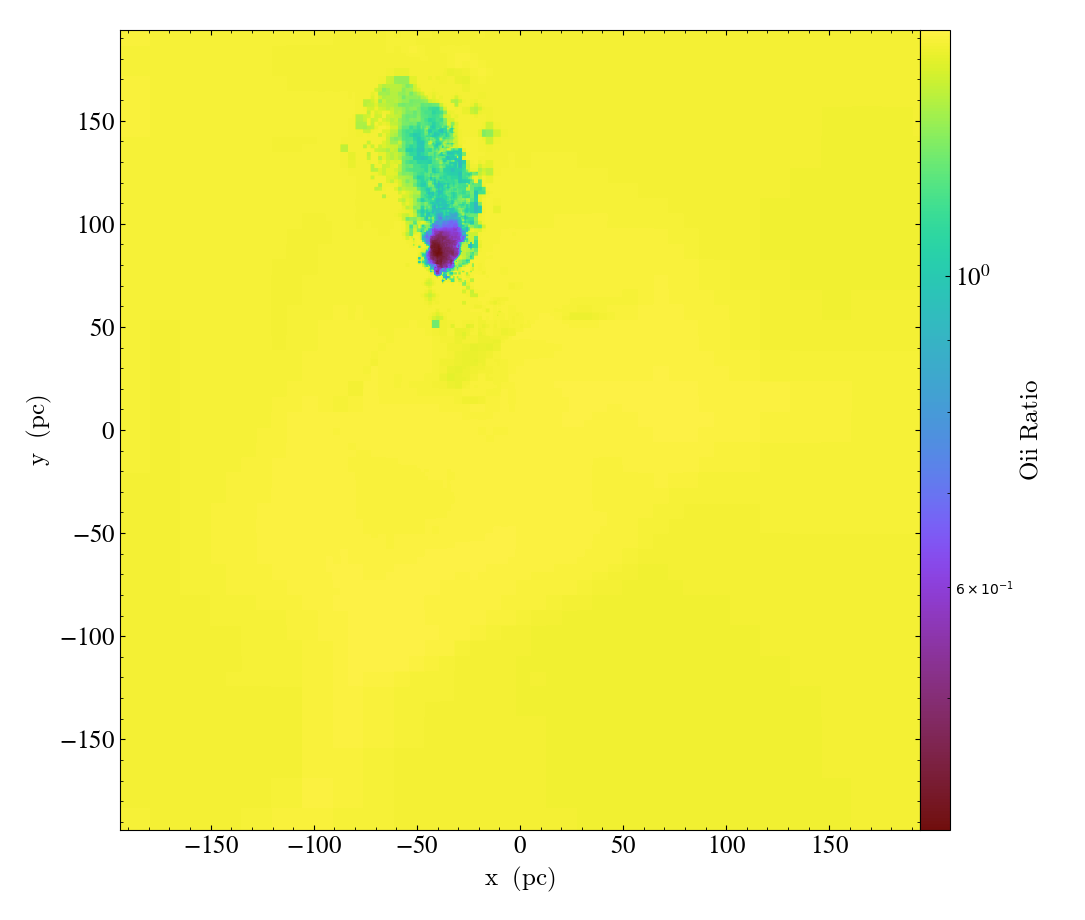

In [7]:
p = yt.ProjectionPlot(ds, "z", ("gas", "OII_ratio"), width=0.0001,
                      weight_field=("gas", "number_density"),
                      buff_size=(1000, 1000),
                      center=[0.49118094, 0.49275361, 0.49473726])

p.show()

yt : [INFO     ] 2024-10-16 23:04:08,245 Projection completed
yt : [INFO     ] 2024-10-16 23:04:08,248 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-16 23:04:08,248 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-16 23:04:08,250 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-16 23:04:08,251 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-16 23:04:08,252 Making a fixed resolution buffer of (('gas', 'H_p1_fraction')) 1000 by 1000



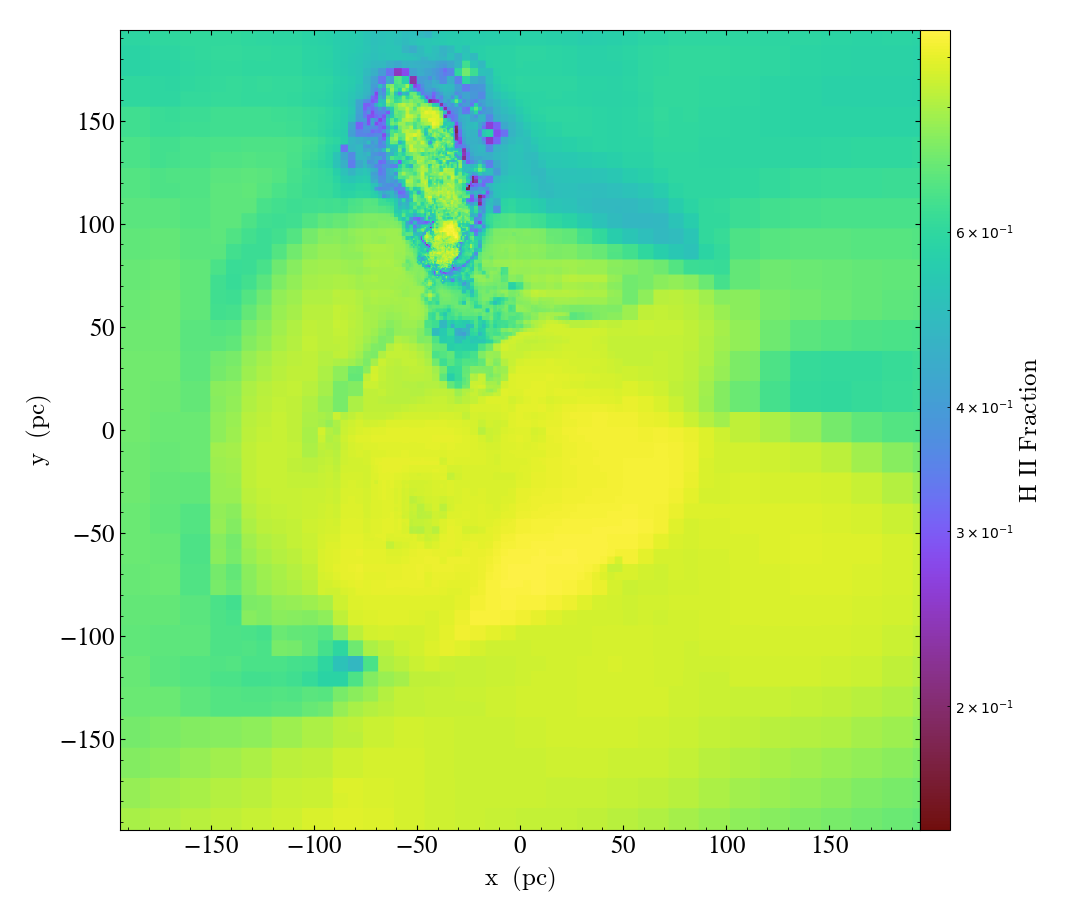

In [8]:
p = yt.ProjectionPlot(ds, "z", ("gas", "H_p1_fraction"), width=0.0001,
                      weight_field=("gas", "number_density"),
                      buff_size=(1000, 1000),
                      center=[0.49118094, 0.49275361, 0.49473726])

p.show()

/var/folders/rh/cscbbcyd02lfdp3qqy7mdmjm0000gn/T/ipykernel_45270/2295670235.py:6: RuntimeWarning: divide by zero encountered in log10
  T = np.log10(data['gas', 'temperature'].value)
yt : [INFO     ] 2024-10-10 13:15:16,702 Projection completed
yt : [INFO     ] 2024-10-10 13:15:16,705 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-10 13:15:16,705 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-10 13:15:16,707 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-10 13:15:16,708 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-10 13:15:16,709 Making a fixed resolution buffer of (('gas', 'OII_emission')) 1000 by 1000



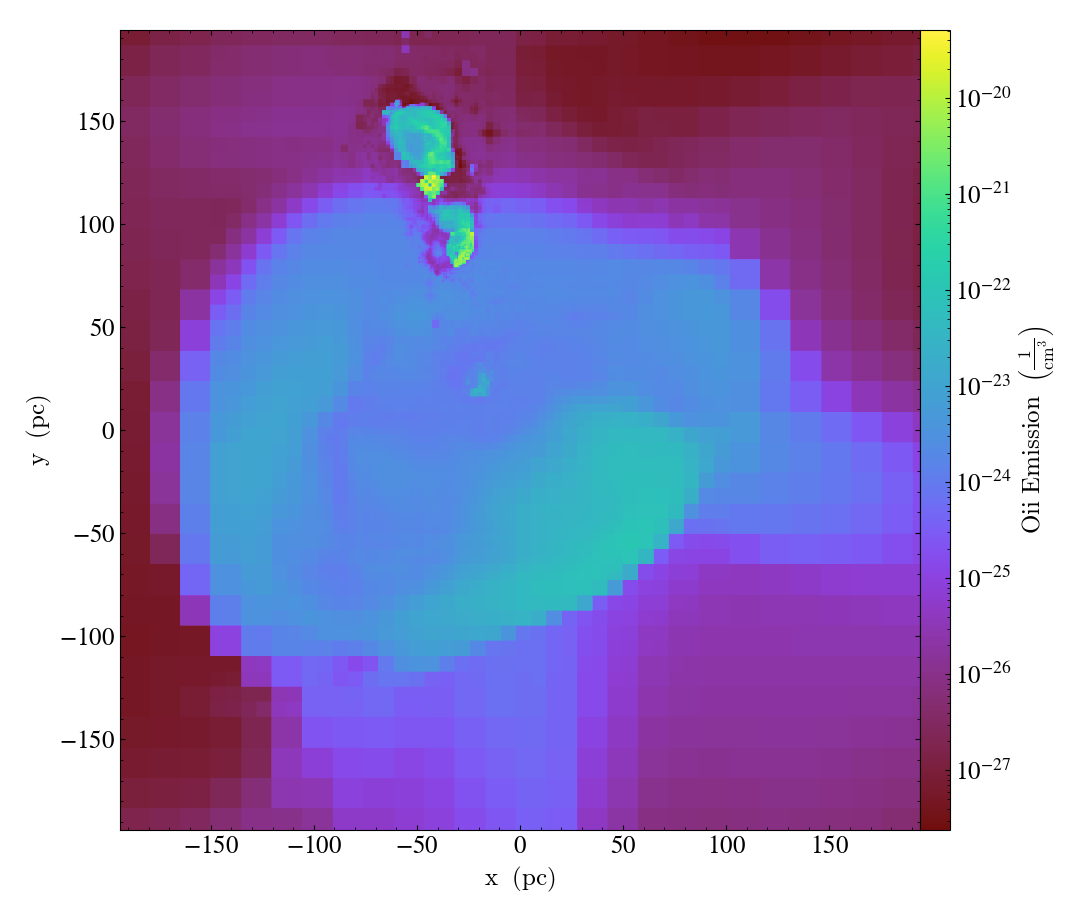

In [10]:
def _OII_emission(field, data):
    interpolator=emission.get_interpolator(3)
    # change to log values
    U = np.log10(data['gas', 'ion-param'].value)
    N = np.log10(data['gas', 'number_density'].value)
    T = np.log10(data['gas', 'temperature'].value)

    Uadj = np.where(U < -6.0, -6.0, U)
    Uadj = np.where(Uadj > 1.0, 1.0, Uadj)

    Nadj = np.where(N < -1.0, -1.0, N)
    Nadj = np.where(Nadj > 6.0, 6.0, Nadj)

    Tadj = np.where(T < 3.0, 3.0, T)
    Tadj = np.where(Tadj > 6.0, 6.0, Tadj)
    
    tup = np.stack((Uadj, Nadj, Tadj), axis=-1)
    return interpolator(tup)*data['gas', 'number_density']

ds.add_field(
    ('gas', 'OII_emission'),
    function=_OII_emission,
    sampling_type='cell',
    #units='erg cm**-2 s**-1',
    units='1/cm**3',
    #dimension=dimensions,
    force_override=True
)

def _OII_emission_2(field, data):
    interpolator=emission.get_interpolator(4)
    # change to log values
    U = np.log10(data['gas', 'ion-param'].value)
    N = np.log10(data['gas', 'number_density'].value)
    T = np.log10(data['gas', 'temperature'].value)

    Uadj = np.where(U < -6.0, -6.0, U)
    Uadj = np.where(Uadj > 1.0, 1.0, Uadj)

    Nadj = np.where(N < -1.0, -1.0, N)
    Nadj = np.where(Nadj > 6.0, 6.0, Nadj)

    Tadj = np.where(T < 3.0, 3.0, T)
    Tadj = np.where(Tadj > 6.0, 6.0, Tadj)
    
    tup = np.stack((Uadj, Nadj, Tadj), axis=-1)
    return interpolator(tup)*data['gas', 'number_density']

ds.add_field(
    ('gas', 'OII_emission_2'),
    function=_OII_emission_2,
    sampling_type='cell',
    #units='erg cm**-2 s**-1',
    units='1/cm**3',
    #dimension=dimensions,
    force_override=True
)

def _O_ratio(field, data):
    return data['OII_emission']/data['OII_emission_2']

ds.add_field(
    ('gas', 'O_ratio'),
    function=_O_ratio,
    sampling_type='cell',
    #units='erg cm**-2 s**-1',
    units='1',
    #dimension=dimensions,
    force_override=True
)

p = yt.ProjectionPlot(ds, "z", ("gas", "OII_emission"), width=0.0001,
                      weight_field=("gas", "number_density"),
                      buff_size=(1000, 1000),
                      center=[0.49118094, 0.49275361, 0.49473726])

p.show()

### Alternatively, Project both OII emission lines then calculate ratio

/var/folders/rh/cscbbcyd02lfdp3qqy7mdmjm0000gn/T/ipykernel_89127/3933899229.py:63: RuntimeWarning: divide by zero encountered in log10
  T = np.log10(data['gas', 'temperature'].value)
yt : [INFO     ] 2024-10-16 23:51:52,509 Projection completed
yt : [INFO     ] 2024-10-16 23:51:52,512 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-16 23:51:52,512 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-16 23:51:52,514 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-16 23:51:52,515 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-16 23:51:52,515 Making a fixed resolution buffer of (('gas', 'intensity_O2_3728.80A_[erg_cm^{-2}_s^{-1}]')) 1000 by 1000
yt : [INFO     ] 2024-10-16 23:52:05,700 Projection completed
yt : [INFO     ] 2024-10-16 23:52:05,703 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-16 23:52:05,703 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-16 23:52:05,706 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-16 23:52:05,706 ylim = 0.492704 0.492804
yt : [INFO     ] 2


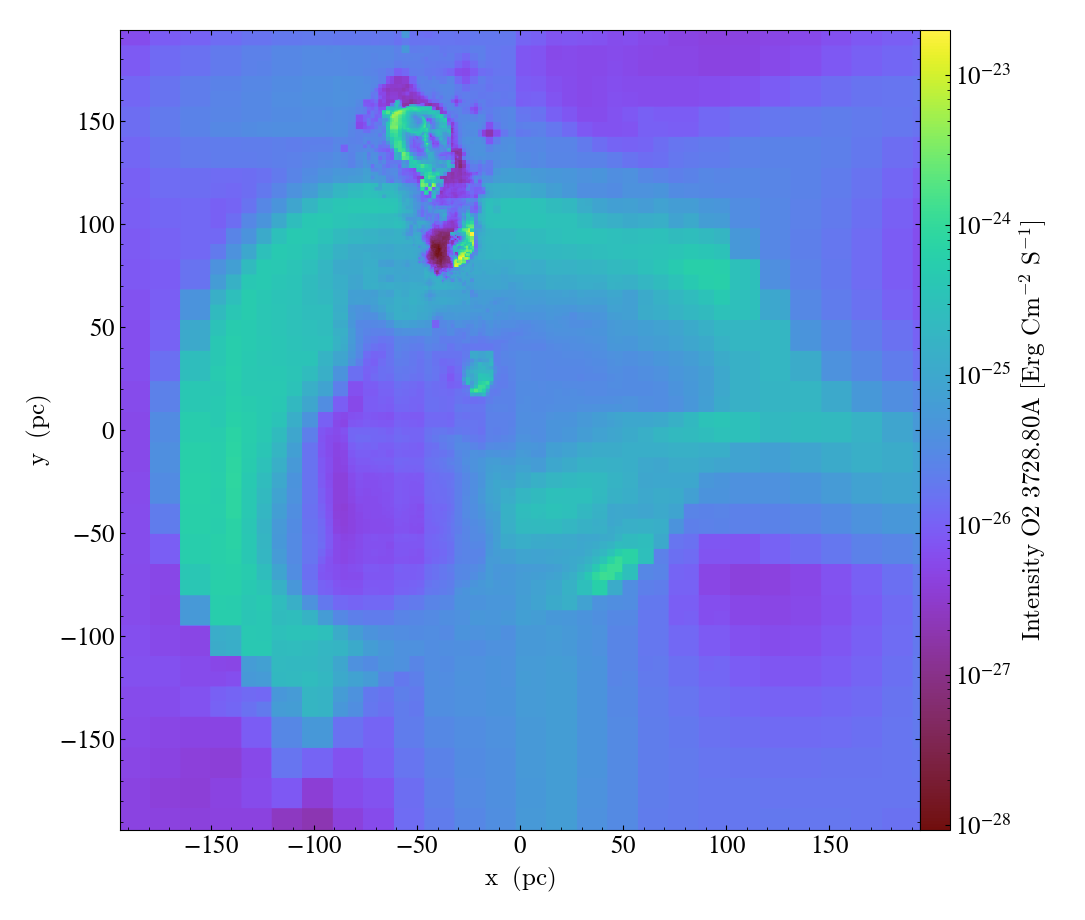


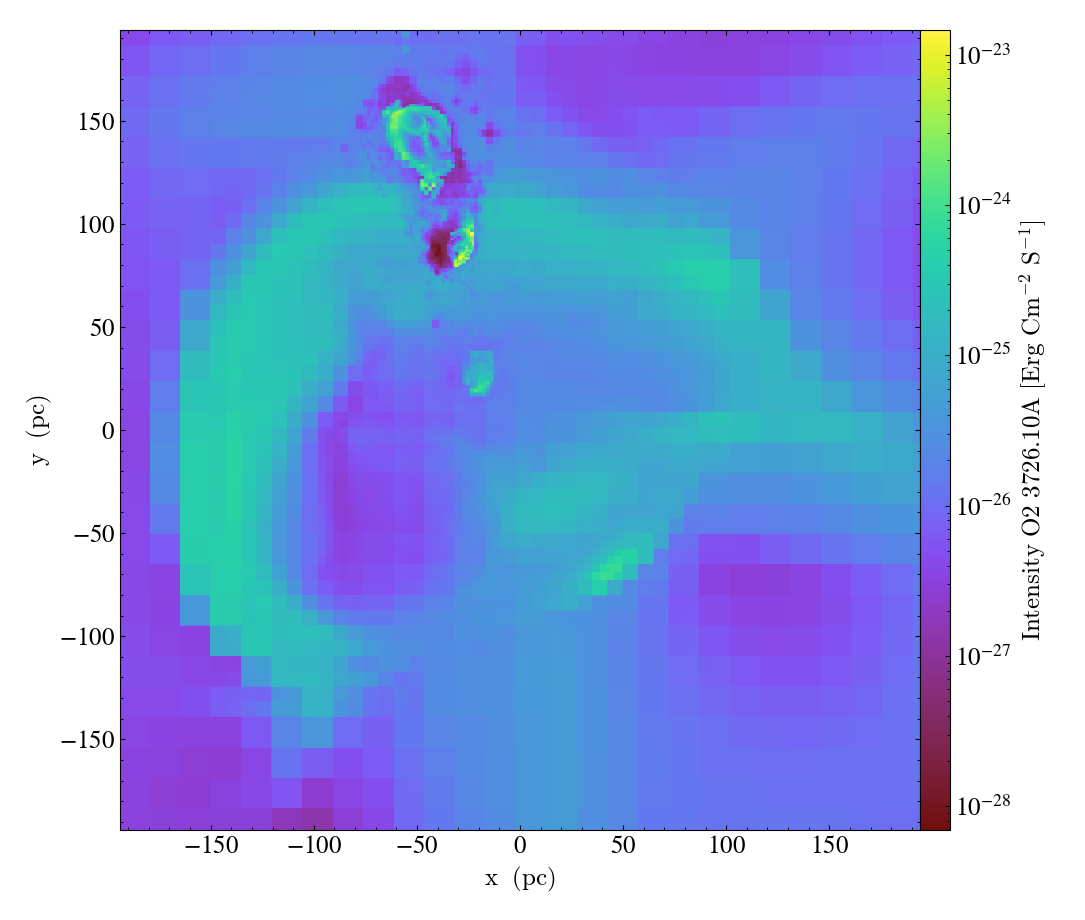

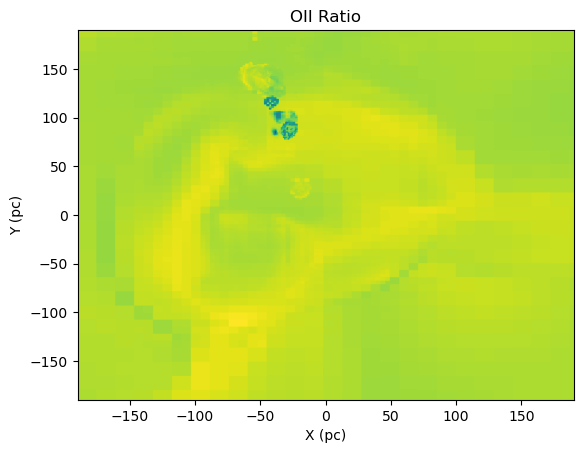

In [25]:
from matplotlib.colors import LogNorm

# Define the center for the projection
center = [0.49118094, 0.49275361, 0.49473726]

# Create Projection Plots
p1 = yt.ProjectionPlot(ds, "z", ("gas", "intensity_O2_3728.80A_[erg_cm^{-2}_s^{-1}]"), width=0.0001,
                      weight_field=("gas", "number_density"), buff_size=(1000, 1000),
                      center=center)

p2 = yt.ProjectionPlot(ds, "z", ("gas", "intensity_O2_3726.10A_[erg_cm^{-2}_s^{-1}]"), width=0.0001,
                      weight_field=("gas", "number_density"), buff_size=(1000, 1000),
                      center=center)

p1.show()
p2.show()

# Fixed-Resolution Buffer from the projection
p1_frb = p1.frb  
p2_frb = p2.frb
p1_img = np.array(p1_frb["gas", "intensity_O2_3728.80A_[erg_cm^{-2}_s^{-1}]"])
p2_img = np.array(p2_frb["gas", "intensity_O2_3726.10A_[erg_cm^{-2}_s^{-1}]"])
ratio = p1_img/p2_img

# Calculate limits for the plot
lbox = 380  # in pc
extent_dens = [-lbox/2, lbox/2, -lbox/2, lbox/2]
dens_norm = LogNorm(np.min(ratio), np.max(ratio))
# Ensure the aspect ratio of the image matches the scatter plot
plt.imshow(ratio, norm=dens_norm, extent=extent_dens, origin='lower', aspect='auto')
plt.xlabel("X (pc)")
plt.ylabel("Y (pc)")
plt.title("OII Ratio")
plt.xlim(-lbox/2, lbox/2)
plt.ylim(-lbox/2, lbox/2)
plt.show()



## Slice Plots

yt : [INFO     ] 2024-10-16 23:24:51,678 max value is 1.39742e+05 at 0.4911709129810333 0.4927761256694794 0.4947503507137299
yt : [INFO     ] 2024-10-16 23:24:52,934 xlim = 0.491126 0.491216
yt : [INFO     ] 2024-10-16 23:24:52,935 ylim = 0.492731 0.492821
yt : [INFO     ] 2024-10-16 23:24:52,936 xlim = 0.491126 0.491216
yt : [INFO     ] 2024-10-16 23:24:52,936 ylim = 0.492731 0.492821
yt : [INFO     ] 2024-10-16 23:24:52,937 Making a fixed resolution buffer of (('gas', 'number_density')) 1000 by 1000



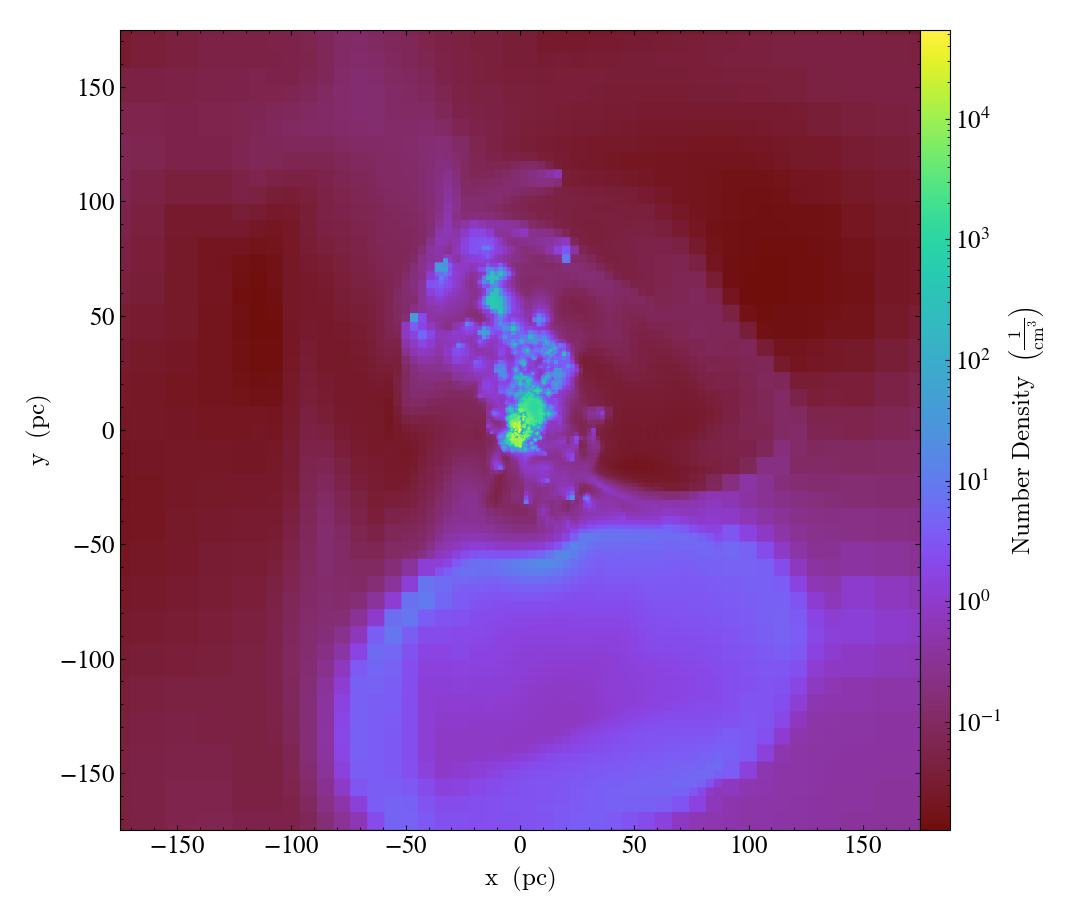

In [19]:
slc = yt.SlicePlot(
    ds,
    "z",
    ("gas", "number_density"),
    #center=[0.49118094, 0.49275361, 0.49473726],
    center=("max", ("gas", "number_density")),
    width=(350, "pc"),
    buff_size=(1000, 1000),
)

#slc.save()
slc.show()

In [63]:
print(ad.quantities.max_location(("gas", "intensity_H1_6562.80A_[erg_cm^{-2}_s^{-1}]")))
print(ad.quantities.max_location(("gas", "density")))

/var/folders/rh/cscbbcyd02lfdp3qqy7mdmjm0000gn/T/ipykernel_89127/1815844088.py:63: RuntimeWarning: divide by zero encountered in log10
  T = np.log10(data['gas', 'temperature'].value)


[unyt_quantity(8.67997483e-15, '(dimensionless)'), unyt_quantity(0.49117072, 'code_length'), unyt_quantity(0.49277569, 'code_length'), unyt_quantity(0.49474852, 'code_length')]
[unyt_quantity(2.75715809e-19, 'g/cm**3'), unyt_quantity(0.49117097, 'code_length'), unyt_quantity(0.49277607, 'code_length'), unyt_quantity(0.49475041, 'code_length')]


/var/folders/rh/cscbbcyd02lfdp3qqy7mdmjm0000gn/T/ipykernel_89127/3069468269.py:63: RuntimeWarning: divide by zero encountered in log10
  T = np.log10(data['gas', 'temperature'].value)
yt : [INFO     ] 2024-10-17 16:25:24,532 xlim = 0.491136 0.491226
yt : [INFO     ] 2024-10-17 16:25:24,533 ylim = 0.492708 0.492799
yt : [INFO     ] 2024-10-17 16:25:24,534 xlim = 0.491136 0.491226
yt : [INFO     ] 2024-10-17 16:25:24,535 ylim = 0.492708 0.492799
yt : [INFO     ] 2024-10-17 16:25:24,536 Making a fixed resolution buffer of (('gas', 'intensity_H1_6562.80A_[erg_cm^{-2}_s^{-1}]')) 1000 by 1000



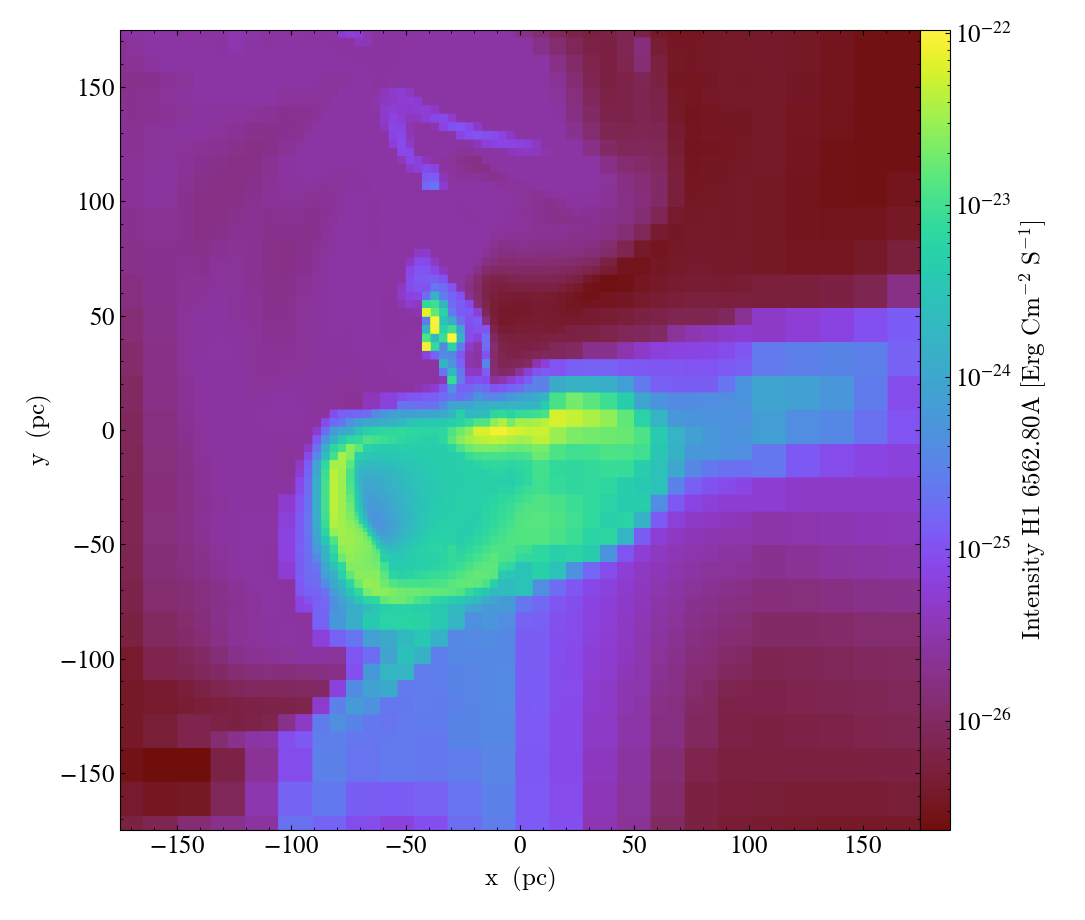

In [61]:
slc = yt.SlicePlot(
    ds,
    "z",
    ("gas", "intensity_H1_6562.80A_[erg_cm^{-2}_s^{-1}]"),
    center=[0.49118094, 0.49275361, 0.49473726],
    #center=("max", ("gas", "intensity_H1_6562.80A_[erg_cm^{-2}_s^{-1}]")),
    width=(350, "pc"),
    buff_size=(1000, 1000),
)

#slc.save()
slc.show()

## Projection in 500pc spherical region

yt : [INFO     ] 2024-10-17 15:44:00,851 Projection completed
yt : [INFO     ] 2024-10-17 15:44:00,852 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-17 15:44:00,852 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-17 15:44:00,854 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-17 15:44:00,854 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-17 15:44:00,855 Making a fixed resolution buffer of (('gas', 'intensity_H1_6562.80A_[erg_cm^{-2}_s^{-1}]')) 1000 by 1000



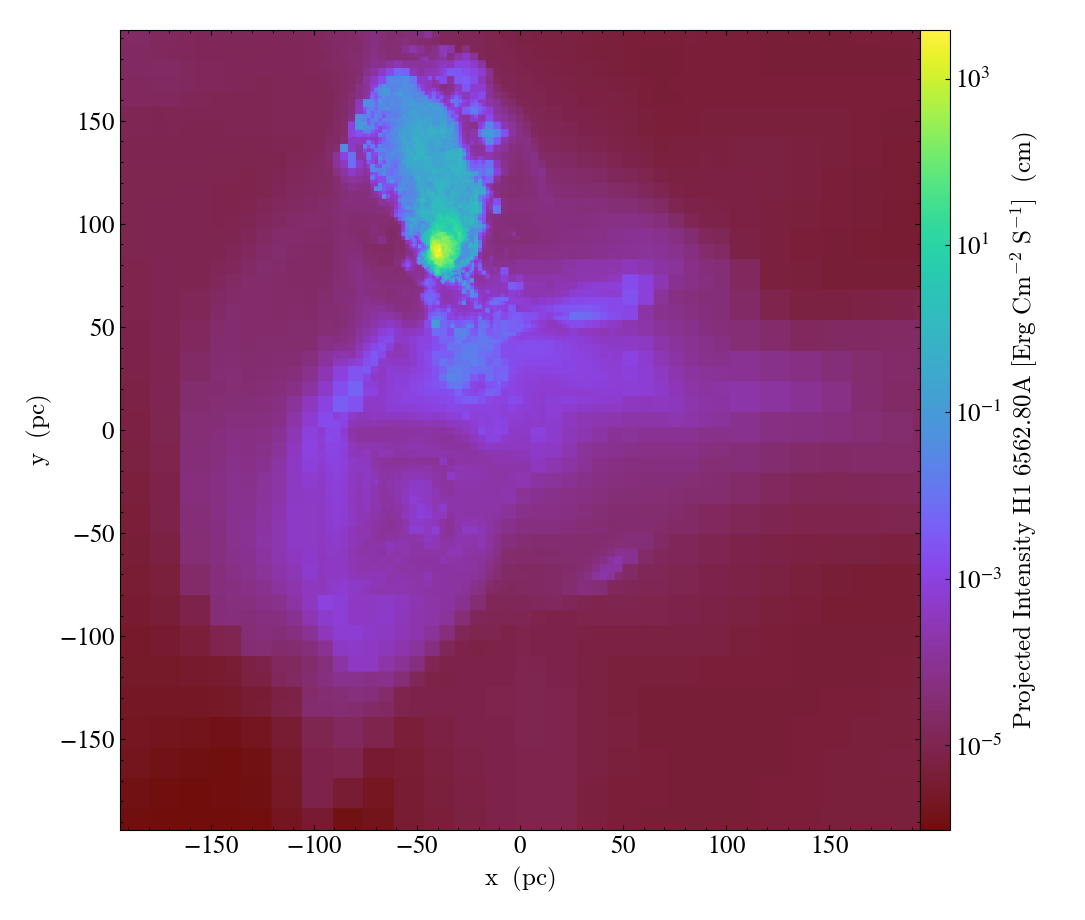

In [34]:
sp = ds.sphere([0.49118094, 0.49275361, 0.49473726], (500, "pc"))

p = yt.ProjectionPlot(ds, "z", ("gas", "intensity_H1_6562.80A_[erg_cm^{-2}_s^{-1}]"), width=0.0001,
                      #weight_field=("gas", "number_density"),
                      buff_size=(1000, 1000),
                      data_source=sp,
                      center=[0.49118094, 0.49275361, 0.49473726])

#p.save()
p.show()

yt : [INFO     ] 2024-10-17 15:50:41,566 Projection completed
yt : [INFO     ] 2024-10-17 15:50:41,566 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-17 15:50:41,566 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-17 15:50:41,568 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-17 15:50:41,568 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-17 15:50:41,569 Making a fixed resolution buffer of (('gas', 'intensity_O3_5006.84A_[erg_cm^{-2}_s^{-1}]')) 1000 by 1000



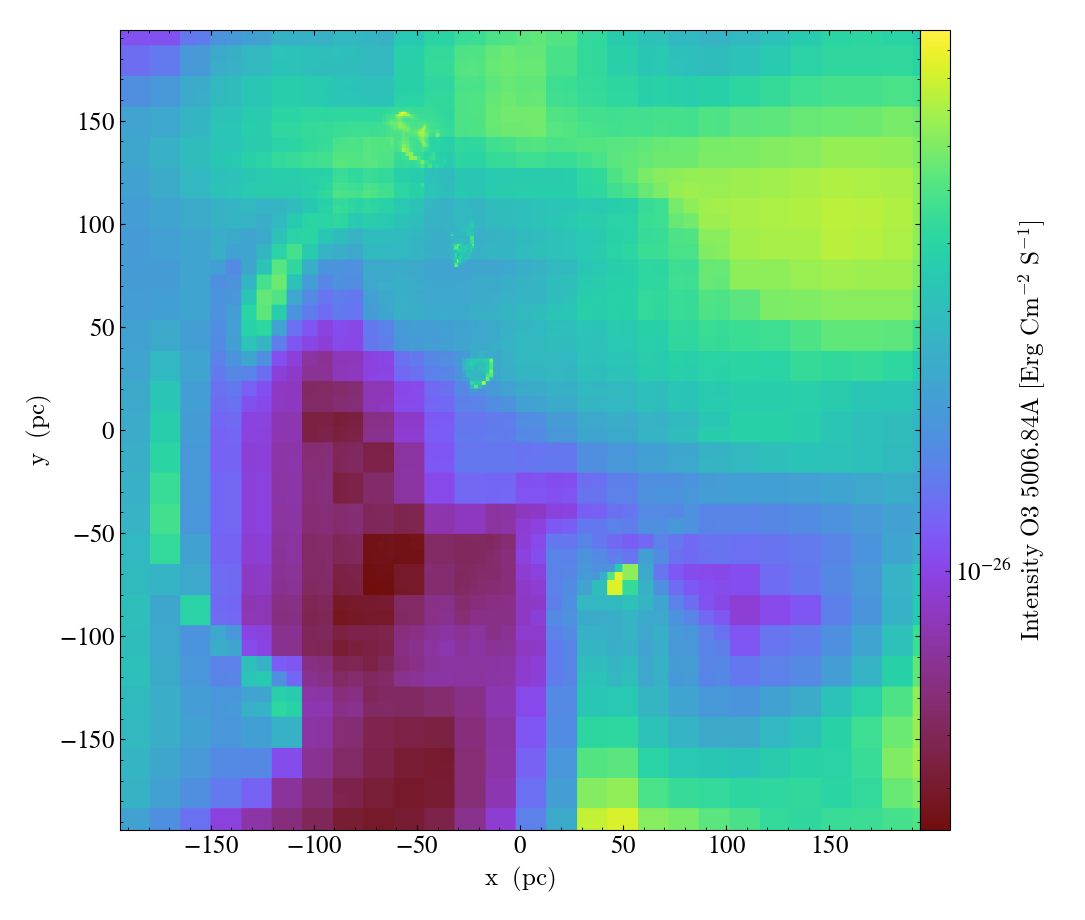

In [40]:
sp = ds.sphere([0.49118094, 0.49275361, 0.49473726], (500, "pc"))

p = yt.ProjectionPlot(ds, "z", ("gas", "intensity_O3_5006.84A_[erg_cm^{-2}_s^{-1}]"), width=0.0001,
                      weight_field=("gas", "metallicity"),
                      buff_size=(1000, 1000),
                      data_source=sp,
                      center=[0.49118094, 0.49275361, 0.49473726])

#p.save()
# metallicity as weight field
# emissivity prop to density squared
p.show()

yt : [INFO     ] 2024-10-17 16:18:39,532 Projection completed
yt : [INFO     ] 2024-10-17 16:18:39,535 xlim = 0.491116 0.491245
yt : [INFO     ] 2024-10-17 16:18:39,535 ylim = 0.492689 0.492818
yt : [INFO     ] 2024-10-17 16:18:39,538 xlim = 0.491116 0.491245
yt : [INFO     ] 2024-10-17 16:18:39,539 ylim = 0.492689 0.492818
yt : [INFO     ] 2024-10-17 16:18:39,540 Making a fixed resolution buffer of (('gas', 'intensity_O3_1660.81A_[erg_cm^{-2}_s^{-1}]')) 1000 by 1000



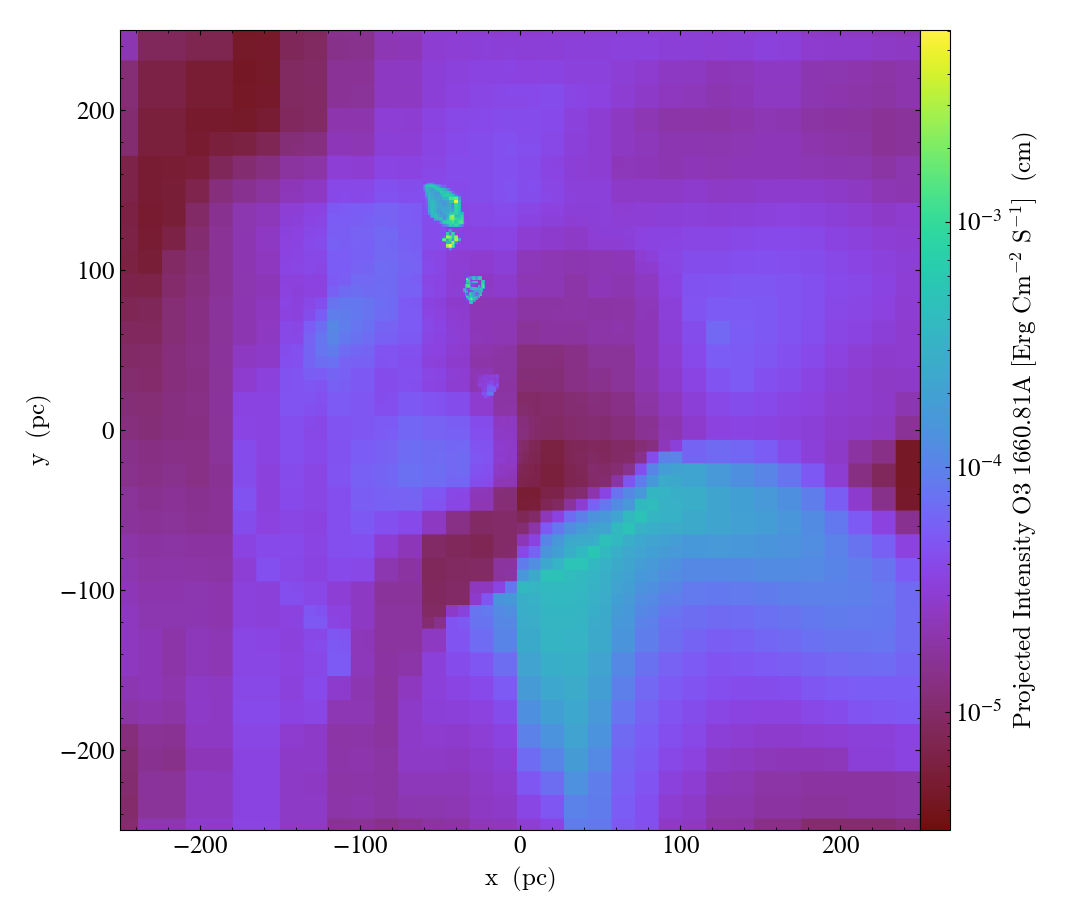

In [59]:
sp = ds.sphere([0.49118094, 0.49275361, 0.49473726], (1000, "pc"))

p = yt.ProjectionPlot(ds, "z", ("gas", "intensity_O3_1660.81A_[erg_cm^{-2}_s^{-1}]"), width=(500, "pc"), #width=0.0001,
                      #weight_field=("gas", "metallicity"),
                      buff_size=(1000, 1000),
                      data_source=sp,
                      center=[0.49118094, 0.49275361, 0.49473726])

#p.save()
# metallicity as weight field
# emissivity prop to density squared
p.show()

yt : [INFO     ] 2024-10-17 16:08:01,886 Projection completed
yt : [INFO     ] 2024-10-17 16:08:01,886 xlim = 0.491116 0.491245
yt : [INFO     ] 2024-10-17 16:08:01,886 ylim = 0.492689 0.492818
yt : [INFO     ] 2024-10-17 16:08:01,888 xlim = 0.491116 0.491245
yt : [INFO     ] 2024-10-17 16:08:01,888 ylim = 0.492689 0.492818
yt : [INFO     ] 2024-10-17 16:08:01,888 Making a fixed resolution buffer of (('gas', 'intensity_O3_1660.81A_[erg_cm^{-2}_s^{-1}]')) 1000 by 1000
yt : [INFO     ] 2024-10-17 16:08:03,096 Projection completed
yt : [INFO     ] 2024-10-17 16:08:03,097 xlim = 0.491116 0.491245
yt : [INFO     ] 2024-10-17 16:08:03,097 ylim = 0.492689 0.492818
yt : [INFO     ] 2024-10-17 16:08:03,098 xlim = 0.491116 0.491245
yt : [INFO     ] 2024-10-17 16:08:03,099 ylim = 0.492689 0.492818
yt : [INFO     ] 2024-10-17 16:08:03,099 Making a fixed resolution buffer of (('gas', 'intensity_O3_1660.81A_[erg_cm^{-2}_s^{-1}]')) 1000 by 1000


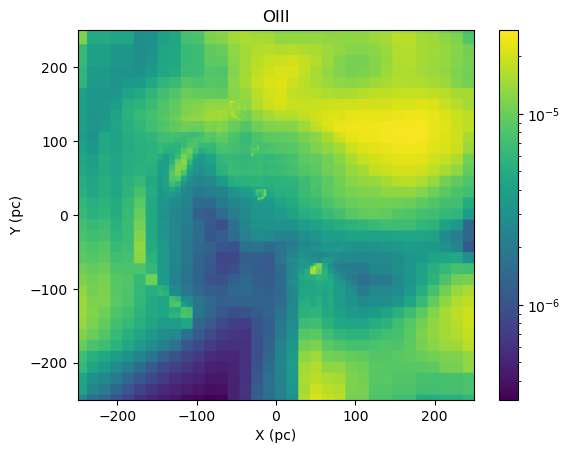

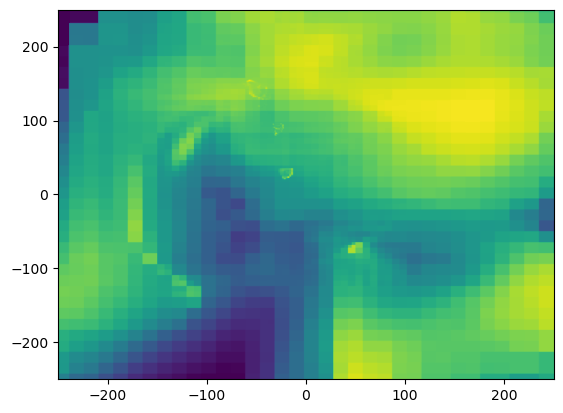

In [55]:
sp1 = ds.sphere([0.49118094, 0.49275361, 0.49473726], (1000, "pc"))
sp2 = ds.sphere([0.49118094, 0.49275361, 0.49473726], (500, "pc"))

p1 = yt.ProjectionPlot(ds, "z", ("gas", "intensity_O3_1660.81A_[erg_cm^{-2}_s^{-1}]"), width=(500, "pc"), #width=0.0001,
                      #weight_field=("gas", "metallicity"),
                      buff_size=(1000, 1000),
                      data_source=sp1,
                      center=[0.49118094, 0.49275361, 0.49473726])

p2 = yt.ProjectionPlot(ds, "z", ("gas", "intensity_O3_1660.81A_[erg_cm^{-2}_s^{-1}]"), width=(500, "pc"), #width=0.0001,
                      #weight_field=("gas", "metallicity"),
                      buff_size=(1000, 1000),
                      data_source=sp2,
                      center=[0.49118094, 0.49275361, 0.49473726])

p1_frb = p1.frb
p1_img = np.array(p1_frb["gas", "intensity_O3_1660.81A_[erg_cm^{-2}_s^{-1}]"])

p2_frb = p2.frb
p2_img = np.array(p2_frb["gas", "intensity_O3_1660.81A_[erg_cm^{-2}_s^{-1}]"])


# Calculate limits for the plot
lbox = 500  # in pc
extent_dens = [-lbox/2, lbox/2, -lbox/2, lbox/2]
dens_norm = LogNorm(np.min(p1_img), np.max(p1_img))
# Ensure the aspect ratio of the image matches the scatter plot
plt.imshow(p1_img, norm=dens_norm, extent=extent_dens, origin='lower', aspect='auto')
plt.xlabel("X (pc)")
plt.ylabel("Y (pc)")
plt.title("OIII")
plt.xlim(-lbox/2, lbox/2)
plt.ylim(-lbox/2, lbox/2)
plt.colorbar()
plt.show()

plt.imshow(p2_img, norm=dens_norm, extent=extent_dens, origin='lower', aspect='auto')
plt.xlim(-lbox/2, lbox/2)
plt.ylim(-lbox/2, lbox/2)
plt.show()

In [ ]:
# Slice plots
# max emission value along line of sight - slice at point -> params 
# projection in specific box/region in z, spherical 300pc diameter, 500pc
# ratio between OII lines - 2 proj plots, np array, plot ratio - sensitive to e- density - compare approaches
# output plots directory 

# Interesting Regime of JWST images: hard emission (xray) from a BH
# cloudy grid runs with different tables - AGN, etc
# merge into ramses sim - combine bins or treat separately - photon densities 5 and 6

# Make a general module combining emission.py for any input Cloudy table, 
# returning a function to work in derived fields, making
# yt plots